In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [1]:
%cd mmsegmentation

/home/modan9012/mmsegmentation


In [2]:
# Pytorch 설치 확인
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

import mmcv
print(mmcv.__version__)

# MMSegmentation 설치 확인
import mmseg
print(mmseg.__version__)

1.12.0+cu116 True
2.1.0
1.2.2


In [3]:
import os.path as osp
import numpy as np
from PIL import Image
import mmcv
import mmengine
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

In [4]:
# dataset root와 이미지, annotation이 위치할 디렉토리 정의
data_root = '/home/modan9012/mmsegmentation/datasets/'
img_dir = 'images/'
ann_dir = 'labels'
# 각 클래스에 대한 팔레트(색상)을 정의
classes = ('background', 'kidney')
palette = [[128,0,0],[0,128,0]]

In [26]:
png_file_count = sum(1 for filename in os.listdir(data_root+ann_dir) if filename.endswith('.png'))

print(png_file_count)

8837


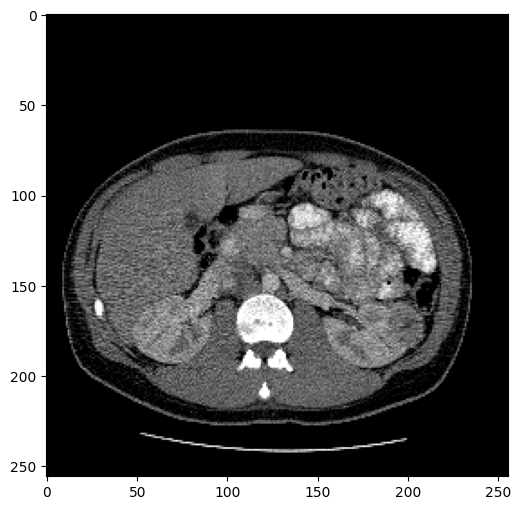

In [28]:
# 다운받은 데이터셋 확인
img = mmcv.imread('/home/modan9012/mmsegmentation/datasets/images/086_040.png')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [29]:
import os.path as osp
import numpy as np
from PIL import Image

# Segmentation map 변환
for file in mmengine.scandir(osp.join(data_root, ann_dir), suffix='.png'):
  seg_map = np.array(Image.open(osp.join(data_root, ann_dir, file)))
  seg_img = Image.fromarray(seg_map).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8))

  # 동일 파일명으로 segmentation map 저장
  output_file = osp.join(data_root, ann_dir, file)
  seg_img.save(output_file)

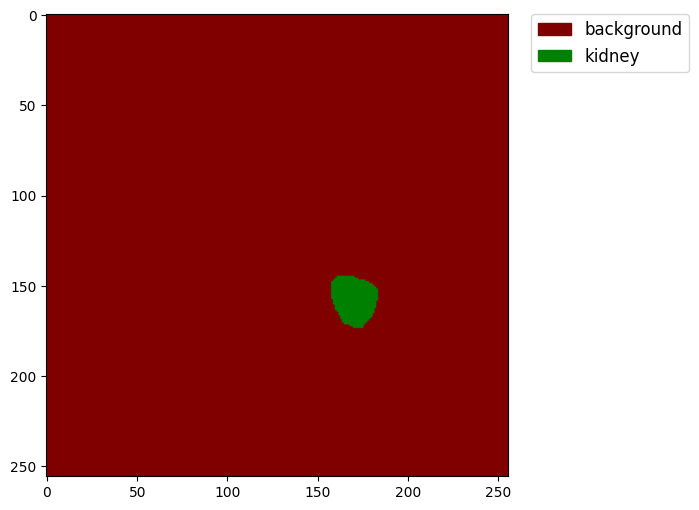

In [30]:
# 변환된 Segmentation map 확인
img = Image.open(f'{data_root}{ann_dir}/085_042.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch for every color(palette)
patches = [mpatches.Patch(color=np.array(palette[i])/255.,
                          label=classes[i]) for i in range(2)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
           fontsize='large')

plt.show()

In [31]:
# 파일명 리스트 생성
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]

In [33]:
import os.path as osp
# split train/val set randomly
split_dir = 'splits'
mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 0.8 as train set
  train_length = int(len(filename_list)*0.8)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 0.2 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [34]:
train_length = int(len(filename_list)*0.8)
print(f'train_length: {train_length}')
print(f'val_length: {len(filename_list) - train_length}')

train_length: 7069
val_length: 1768


In [5]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset


@DATASETS.register_module()
class KiTS21Datasets(BaseSegDataset):
	# 클래스, 팔레트 정보에대한 딕셔너리 METAINFO 생성
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)

In [17]:
from mmengine import Config
cfg = Config.fromfile('segmenter_vit-t_mask_8xb1-160k_ade20k-512x512.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
backbone_norm_cfg = dict(eps=1e-06, requires_grad=True, type='LN')
checkpoint = 'https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/segmenter/vit_tiny_p16_384_20220308-cce8c795.pth'
crop_size = (
    512,
    512,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        127.5,
        127.5,
        127.5,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        512,
    ),
    std=[
        127.5,
        127.5,
        127.5,
    ],
    type='SegDataPreProcessor')
data_root = 'data/ade/ADEChallengeData2016'
dataset_type = 'ADE20KDataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=16000, type='CheckpointHook'),
    early_stopping=dict(monitor='mIoU', patience=20, type='EarlyStoppingHook'),
    logger=dict(interval=50, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualiz

In [18]:
cfg.norm_cfg = dict(type='LN', requires_grad=True)
cfg.crop_size = (256,256)
cfg.model.data_preprocessor.size = (256,256)
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.num_classes = 3
cfg.model.decode_head.out_channels= 3
cfg.model.decode_head.loss_decode=dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)
cfg.model.decode_head.threshold = 0.3

cfg.optim_wrapper.optimizer.lr = 0.001

# 데이터셋 타입과 경로를 수정
cfg.dataset_type = 'KiTS21Datasets'
cfg.data_root = data_root
# 트레이닝 데이터 로더의 배치 사이즈를 설정
cfg.train_dataloader.batch_size = 16
# 트레이닝 파이프라인을 설정
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations',reduce_zero_label=False),
    dict(type='RandomResize', scale=(256, 256), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=(256, 256), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='PackSegInputs'),
]
# 테스트 파이프라인을 설정
cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(256, 256), keep_ratio=True),
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]

#train dataloader 설정
cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'
#validation dataloader 설정
cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'


#사전학습된 모델 checkpoint 불러오기
cfg.load_from = './work_dirs/KiTS21-v5/iter_25000.pth'


#로그 디렉토리 설정
cfg.work_dir = './work_dirs/KiTS21_lr0.001_epoch300_batch16_v2'

cfg.train_cfg.type='IterBasedTrainLoop'
cfg.train_cfg.val_interval = 1000
cfg.train_cfg.max_iters= 107600 # 총 300 epoch
cfg.default_hooks.timer=dict(type='IterTimerHook')
cfg.default_hooks.logger.interval = 50
cfg.default_hooks.checkpoint.interval = 5000


#결과 재현을 위한 시드 값을 설정
cfg['randomness'] = dict(seed=0)

#최종 설정(config)을 출력
print(f'Config:\n{cfg.pretty_text}')

Config:
backbone_norm_cfg = dict(eps=1e-06, requires_grad=True, type='LN')
checkpoint = 'https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/segmenter/vit_tiny_p16_384_20220308-cce8c795.pth'
crop_size = (
    256,
    256,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        127.5,
        127.5,
        127.5,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        512,
    ),
    std=[
        127.5,
        127.5,
        127.5,
    ],
    type='SegDataPreProcessor')
data_root = '/home/modan9012/mmsegmentation/datasets/'
dataset_type = 'KiTS21Datasets'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=5000, type='CheckpointHook'),
    early_stopping=dict(monitor='mIoU', patience=20, type='EarlyStoppingHook'),
    logger=dict(interval=50, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
 

In [19]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

04/11 14:52:43 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.19 | packaged by conda-forge | (default, Mar 20 2024, 12:47:35) [GCC 12.3.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 0
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: gcc (Debian 10.2.1-6) 10.2.1 20210110
    PyTorch: 1.12.0+cu116
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.6
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-

In [20]:
# 모델 학습 진행
runner.train()

04/11 14:52:49 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/segmenter/vit_tiny_p16_384_20220308-cce8c795.pth
Resize the pos_embed shape from torch.Size([1, 577, 192]) to torch.Size([1, 1025, 192])
The model and loaded state dict do not match exactly

unexpected key in source state_dict: patch_embed.projection.bias

Loads checkpoint by local backend from path: ./work_dirs/KiTS21-v5/iter_25000.pth
04/11 14:52:51 - mmengine - INFO - Load checkpoint from ./work_dirs/KiTS21-v5/iter_25000.pth
04/11 14:52:51 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
04/11 14:52:51 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
04/11 14:52:51 - mmengine - INFO - Checkpoints will be saved to /home/m

/opt/conda/envs/openmmlab/lib/python3.8/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


04/11 14:56:36 - mmengine - INFO - Iter(val) [  50/1768]    eta: 0:00:46  time: 0.0182  data_time: 0.0015  memory: 107  
04/11 14:56:37 - mmengine - INFO - Iter(val) [ 100/1768]    eta: 0:00:37  time: 0.0175  data_time: 0.0014  memory: 107  
04/11 14:56:38 - mmengine - INFO - Iter(val) [ 150/1768]    eta: 0:00:34  time: 0.0180  data_time: 0.0014  memory: 107  
04/11 14:56:39 - mmengine - INFO - Iter(val) [ 200/1768]    eta: 0:00:32  time: 0.0177  data_time: 0.0014  memory: 107  
04/11 14:56:40 - mmengine - INFO - Iter(val) [ 250/1768]    eta: 0:00:30  time: 0.0183  data_time: 0.0014  memory: 107  
04/11 14:56:41 - mmengine - INFO - Iter(val) [ 300/1768]    eta: 0:00:28  time: 0.0186  data_time: 0.0015  memory: 107  
04/11 14:56:42 - mmengine - INFO - Iter(val) [ 350/1768]    eta: 0:00:27  time: 0.0179  data_time: 0.0015  memory: 107  
04/11 14:56:43 - mmengine - INFO - Iter(val) [ 400/1768]    eta: 0:00:26  time: 0.0184  data_time: 0.0016  memory: 107  
04/11 14:56:44 - mmengine - INFO

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (adap_padding): AdaptivePadding()
      (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16), bias=False)
    )
    (drop_after_pos): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (ln1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
          )
          (proj_drop): Dropout(p=0.0, inplace=False)
          (dropout_layer): Dropout(p=0.0, inplace=False)
        )
        (ln2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (ffn): FFN(
          (layers): Sequential(
            (0): Sequential(
              (0): Linear(in_features=192, out_features=768, bias=True)
              (1): GELU(approx

### inference 결과 시각화

/home/modan9012/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
/opt/conda/envs/openmmlab/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


Loads checkpoint by local backend from path: ./work_dirs/KiTS21_lr0.001_epoch300_batch16/iter_40000.pth


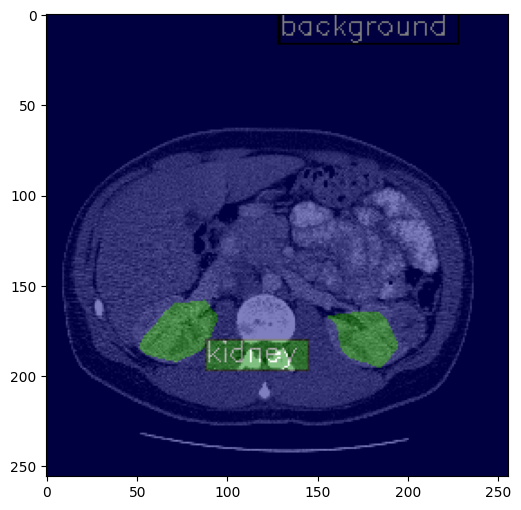

In [21]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = './work_dirs/KiTS21_lr0.001_epoch300_batch16/iter_40000.pth'
model = init_model(cfg, checkpoint_path,'cuda:0')

img = mmcv.imread('/home/modan9012/mmsegmentation/datasets/images/086_040.png')
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))